# Traffic Sign Recognition

The Dataset: 

# Initialization

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pathlib
import os
import timeit
import itertools

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
# metrics
import tensorflow_addons as tfa 

# cv2
import cv2

# sklearn
from sklearn.metrics import confusion_matrix

# MLOps
import wandb
from wandb.keras import WandbCallback

# General Parameters

In [3]:
# get num of classes
def get_num_classes(path):
    num_cats = 0
    for fname in os.listdir(path):
        try:
            bool = type(int(fname)) is int
            num_cats +=1
        except:
            pass
    return num_cats

In [4]:
# location of the data
base_dir = './dataset/GTSRB'
train_dir = './dataset/GTSRB/Train'
test_dir = './dataset/GTSRB/Test'

# dataset metadata
train_meta = './dataset/GTSRB/Train.csv'
test_meta = './dataset/GTSRB/Test.csv'

## Helper Functions

In [5]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, color='blue', label='Training acc')
        plt.plot(epochs, val_acc, color='gray', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# plot Confusion Matrix
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot a test image

def get_input_img(sign_class, img_height, img_width, index = 0, dataset='Test'):
    def reshape_img(img):
        img = cv2.resize(img, (img_height,img_width))
        return np.expand_dims(img, axis=0)

    if dataset == 'Train':
        file_path = base_dir + '/Train/' + str(sign_class) + '/'
        file_name = os.listdir(file_path)[index]
        img = cv2.imread(file_path + file_name)
    
    if dataset == 'Test':
        meta = pd.read_csv('./dataset/GTSRB/Test.csv')
        file = meta[meta['ClassId'] == sign_class]['Path'].values[index]
        img = cv2.imread(base_dir + '/' + file)        

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    return reshape_img(img)
        

def plot_feature_maps(model, img):
    successive_outputs = [layer.output for layer in model.layers[1:]]
    inputs = model.inputs
    outputs = successive_outputs
    filters = Model(inputs=inputs, outputs=outputs)
    feature_maps = filters.predict(img)
    layer_names = [layer.name for layer in model.layers]
    for layer_name, feature_map in zip(layer_names, feature_maps):
        print(feature_map.shape)
        if len(feature_map.shape) == 4:
            # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x

            #Display the grid
            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='viridis' )
        

## MLOps

Weights an Biases init

In [6]:
!wandb login

wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)


In [7]:
#Generic dataset parameters
img_width, img_height = 32, 32
batch_size = 256
cat_num = get_num_classes(train_dir)

# Dataset exploration and preprocessing

## Simple Keras based data augmentation

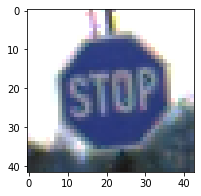

In [8]:
# loading an image sample
img = get_input_img(sign_class=14, img_height=img_height, img_width=img_width, index=31, dataset='Train')

def plot_augmented_samples (batch):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
    # generate batch of images
    for i in range(3):
	    # convert to unsigned integers
	    image = next(aug_iter)[0].astype('uint8')
	    # plot image
	    ax[i].imshow(image)
	    ax[i].axis('off')
    

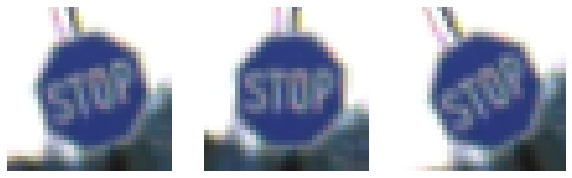

In [9]:
# image rotation
datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

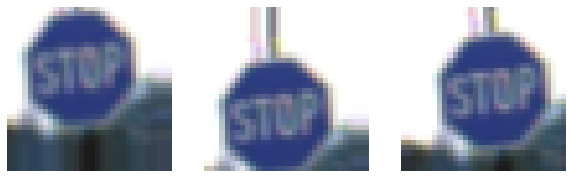

In [10]:
# height and width of the image
datagen = ImageDataGenerator(width_shift_range=.2, 
        height_shift_range=.2,
        fill_mode='nearest'
        )
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

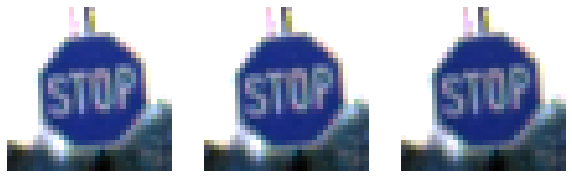

In [11]:
# brightness
datagen = ImageDataGenerator(brightness_range=[1,1.2])
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

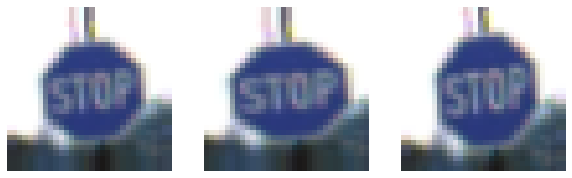

In [12]:
# brightness
datagen = ImageDataGenerator(zoom_range=0.2)  # zoom
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

NOTE:
- We opt not to use zoom as it will distort the sign shapes
- We also opt not to horizontal and vertical flips and signs have directional information which would be lost

Found 27447 images belonging to 43 classes.


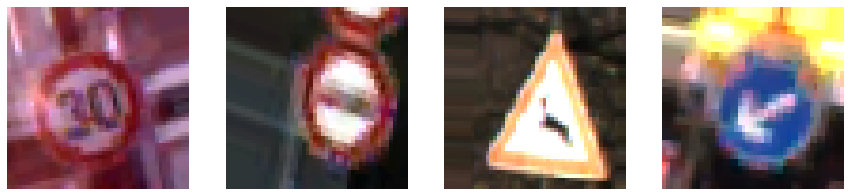

In [13]:
# dry running the generator and fine-tunning the parameters

train_datagen = ImageDataGenerator(validation_split=0.3, 
    # we will not use vertical/horizontal flip as signs have directional information that is revelant
    # adding a img rotation of up to 20º
    rotation_range=20,
    # adding a img translation of up to 20% of the image size
    width_shift_range=.2, 
    height_shift_range=.2,
    fill_mode='nearest',
    # adding a brightness range of 1 to 1.2 - after visual inspection
    brightness_range=[1,1.2],
    # zoom
    zoom_range=0.2
    )
        
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(48,48),
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    class_mode='categorical'
    )

# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image[0])

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')


## Histogram Streching
https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   3.,
         11.,   3.,   2.,   2.,  10.,  58.,  50.,  62.,  25.,  32.,  53.,
         60.,  88.,  43.,  66.,  28.,  49.,  29.,  45.,  43.,  27.,  48.,
         27.,  28.,  26.,  37.,  23.,  26.,  19.,  32.,  28.,  26.,  31.,
         23.,  34.,  32.,  76.,  55.,  66.,  65.,  35.,  28.,  17.,  24.,
         18.,  29.,  24.,  28.,   8.,  19.,  23.,  12.,  15.,   9.,  15.,
          8.,  12.,   8.,  10.,   9.,   2.,   9.,   8.,  11.,   6.,   8.,
          8.,  12.,   8.,   8.,  10.,   7.,   9.,   5.,  11.,   9.,   9.,
          6.,  14.,  12.,   5.,  10.,   7.,   8.,   3.,  18.,  11.,  23.,
        971.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95,  25.5 ,  28.05,  30.6 ,  33.15,  35.7 ,  38.25,
         40.8 ,  43.35,  45.9 ,  48.45,  51.  ,  53.55,  56.1 ,  58.65,
         61.2 ,  63.75,  66.3 ,  68.85,  71.4 ,  73.95,  76.5 ,  79.05,
         81.6 ,  84.15,  86.7 

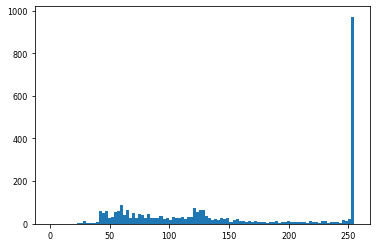

In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 
equ = cv2.equalizeHist(img)
plt.hist(img.flat, bins=100, range=(0, 255))


(array([1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 1., 2., 0., 1., 1., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0.,
        2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95,  25.5 ,  28.05,  30.6 ,  33.15,  35.7 ,  38.25,
         40.8 ,  43.35,  45.9 ,  48.45,  51.  ,  53.55,  56.1 ,  58.65,
         61.2 ,  63.75,  66.3 ,  68.85,  71.4 ,  73.95,  76.5 ,  79.05,
         81.6 ,  84.15,  86.7 ,  89.25,  91.8 ,  94.35,  96.9 ,  99.45,
        102.  , 104.55, 107.1 , 109.65, 112.2 , 114.75, 117.3 , 119.85,
        122.4 , 124.95, 127.5 , 130.05, 132.6 , 135.15, 137.7 , 140.25,
        142.8 , 145.35, 147.9 , 150.45, 153.  

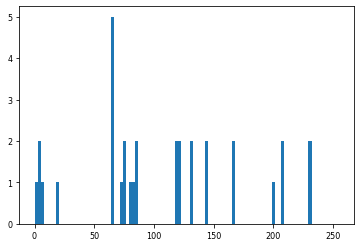

In [19]:
plt.hist(equ.flat, bins=100, range=(0, 255))

/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_21665/2370820719.py:26: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 4), dtype=np.object)


NameError: name 'plot_img_and_hist' is not defined

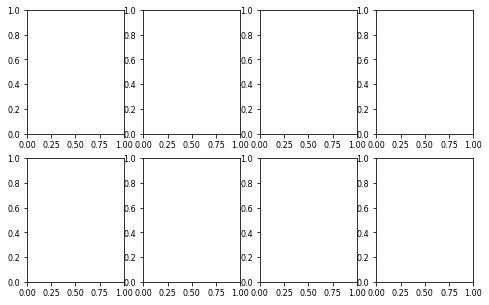

In [16]:
# Import skimage modules
from skimage import data, img_as_float
from skimage import exposure

# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure

# Set font size for images
plt.rcParams['font.size'] = 8

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Histogram Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

#### Everything below here is just to create the plot/graphs ####

# Display results
fig = plt.figure(figsize=(8, 5)) 
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)
    
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [14]:
# training dataset
# With Keras data augmentation

def get_train_val_data(train_dir, img_width, img_height, batch_size, seed):
    #training dataset
    train_datagen = ImageDataGenerator(validation_split=0.3, 
        # we will not use vertical/horizontal flip as signs have directional information that is revelant
        # adding a img rotation of up to 20º
        rotation_range=20,
        # adding a img translation of up to 20% of the image size
        width_shift_range=.2, 
        height_shift_range=.2,
        fill_mode='nearest',
        # adding a brightness range of 1 to 1.2 - after visual inspection
        brightness_range=[1,1.2],
        # zoom
        zoom_range=0.2,
        rescale=1./255)
        
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        shuffle=True,
        seed=seed,
        class_mode='categorical')

    # validation dataset
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        seed=seed,
        class_mode='categorical'
        )

    return train_generator, val_generator

def get_test_data(test_dir, labels_path, img_width, img_height, batch_size):
    #test dataset
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(labels_path, dtype=str),
        directory = test_dir,
        x_col = 'Path',
        y_col = 'ClassId',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical'
        )
    
    return test_generator

In [111]:
train_generator, val_generator = get_train_val_data(train_dir, img_width, img_height, batch_size, seed=1)

Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [112]:
test_generator = get_test_data(base_dir, test_meta, img_width, img_height, batch_size)

Found 12630 validated image filenames belonging to 43 classes.


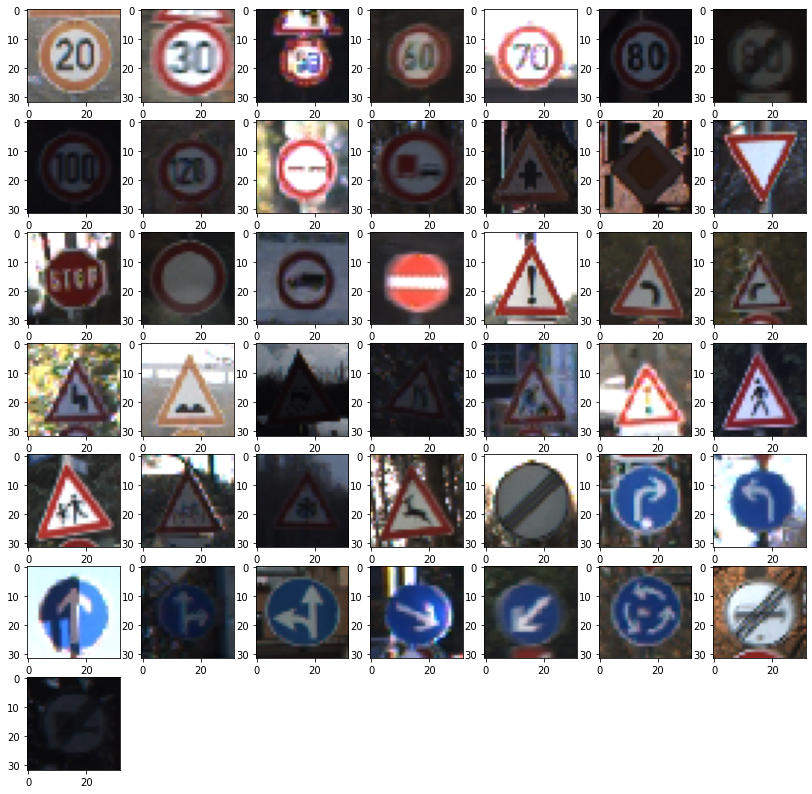

In [113]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(cat_num):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(img_width, img_height))
    plt.imshow(img)
plt.show()

## Class Distribution

In [114]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

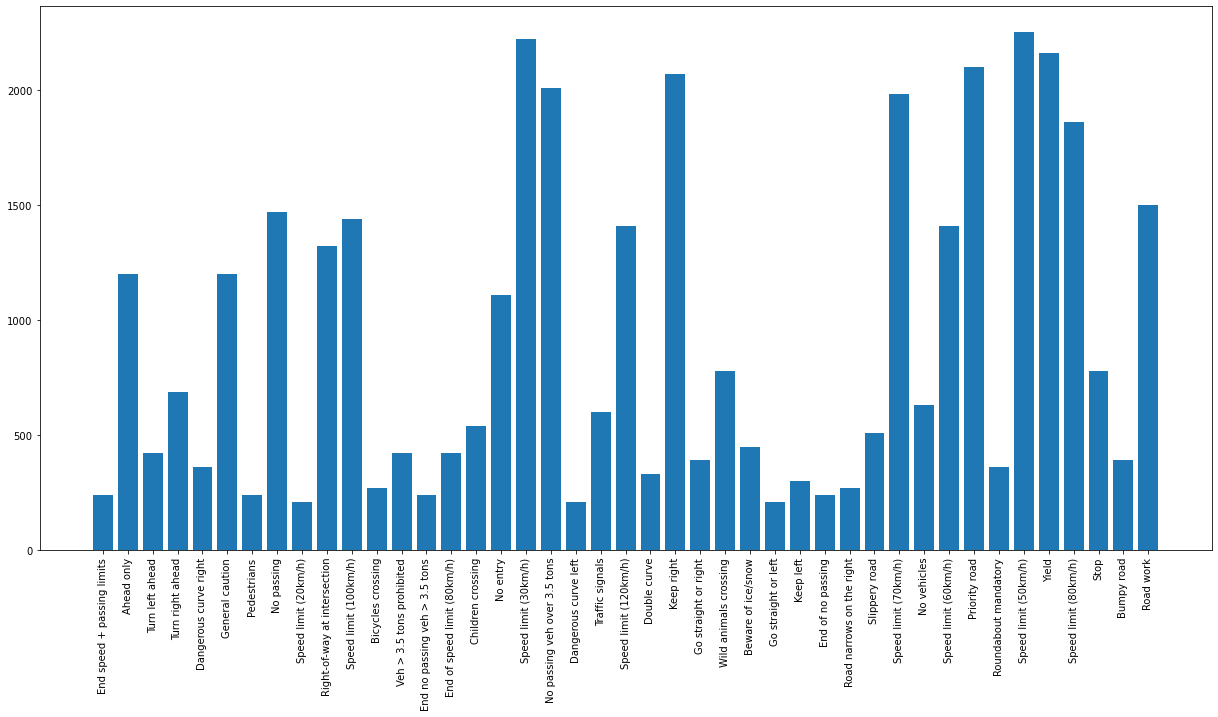

In [115]:
# determining the training data distribution per category
folders = next(os.walk(train_dir))[1]

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Analysis of the dataset

1. We can tell the image size is 
2. Some of the images have issues with low lighting / contrast / saturation which may become a problem for the model
3. The data is highly unbalanced

# Model Architectures

## Generic Paramters

In [116]:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

## Baseline

The first CNN we are going to build consists on the following: 
1. A Convolutional layer followed by a MaxPooling layer; 
2. A second Convolutional layer followed by another MaxPooling layer; 
3. A Flatten layer (this is the input layer for the fully connected part of the CNN); 
4. A Dense Layer (this is the first hidden layer for the fully connected part of the CNN)
5. A second Dense layer (this is the output layer for the fully connected part of the CNN).
<br>

Please be mindful regarding the details below:
- The first and second Convolutional layers should contain 32 neurons (filters), with a filter of size 3x3 and an input shape of 64x64x3;
- The first and second MaxPooling layer should have a size of 2x2;
- The first Dense layer should have 128 neurons and the activation function should be the relu, while the second Dense layer should contain 1 neuron and the softmax as the activation function.

In [117]:
baseline_model = Sequential()
# Refference: DLNN lecture week 6
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(32, 32, 3)))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
baseline_model.add(Flatten())
# MLP - hidden layer
baseline_model.add(Dense(units=128, activation=relu))
# MLP - output layer
baseline_model.add(Dense(units=43, activation=softmax))

# Check built model:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 128)               1

2022-01-07 16:03:34.729184: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training And Evaluating The Model

In [119]:
# adding f1-score
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average=None)

In [120]:
from tensorflow.keras import optimizers 

baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1])

In [121]:
# Common attributes:
mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [122]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 8
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [124]:
# MLOps init and callback
wandb.init(name='CNN_TS_baseline_b256_e100_DA' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/100
5/5 [==============================] - 28s 7s/step - loss: 3.6777 - acc: 0.0500 - f1_score: 0.0089 - val_loss: 3.5868 - val_acc: 0.0582 - val_f1_score: 0.0036
Epoch 2/100
5/5 [==============================] - 27s 6s/step - loss: 3.5672 - acc: 0.0664 - f1_score: 0.0055 - val_loss: 3.5385 - val_acc: 0.0828 - val_f1_score: 0.0112
Epoch 3/100
5/5 [==============================] - 20s 5s/step - loss: 3.5253 - acc: 0.0812 - f1_score: 0.0134 - val_loss: 3.5127 - val_acc: 0.0611 - val_f1_score: 0.0057
Epoch 4/100
5/5 [==============================] - 16s 4s/step - loss: 3.4711 - acc: 0.0984 - f1_score: 0.0153 - val_loss: 3.4595 - val_acc: 0.0992 - val_f1_score: 0.0145
Epoch 5/100
5/5 [==============================] - 18s 4s/step - loss: 3.4077 - acc: 0.0969 - f1_score: 0.0170 - val_loss: 3.4141 - val_acc: 0.1004 - val_f1_score: 0.0212
Epoch 6/100
5/5 [==============================] - 15s 4s/step - loss: 3.2768 - acc: 0.1336 - f1_score: 0.0297 - val_loss: 3.3718 - val_acc: 0.10

acc,▁▁▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▁▂▂▃▃▄▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███
val_loss,██▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
acc,0.51484
best_epoch,80
best_val_loss,2.09011
epoch,88
loss,1.48329


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


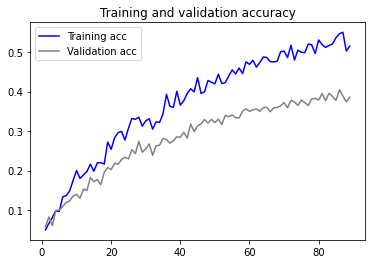

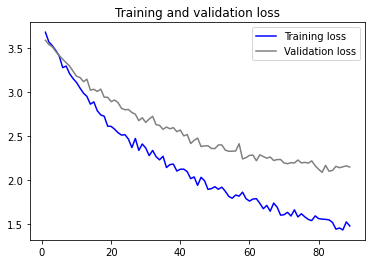

In [125]:
plot_results(history_baseline)

Confusion matrix, without normalization
[[ 0  3  3 ...  1  0  1]
 [ 0 34 40 ... 15 17 15]
 [ 0 28 37 ... 18 21  9]
 ...
 [ 0 26 30 ... 10 12 10]
 [ 0 20 18 ... 14  9 15]
 [ 0 19 31 ... 14 15 17]]


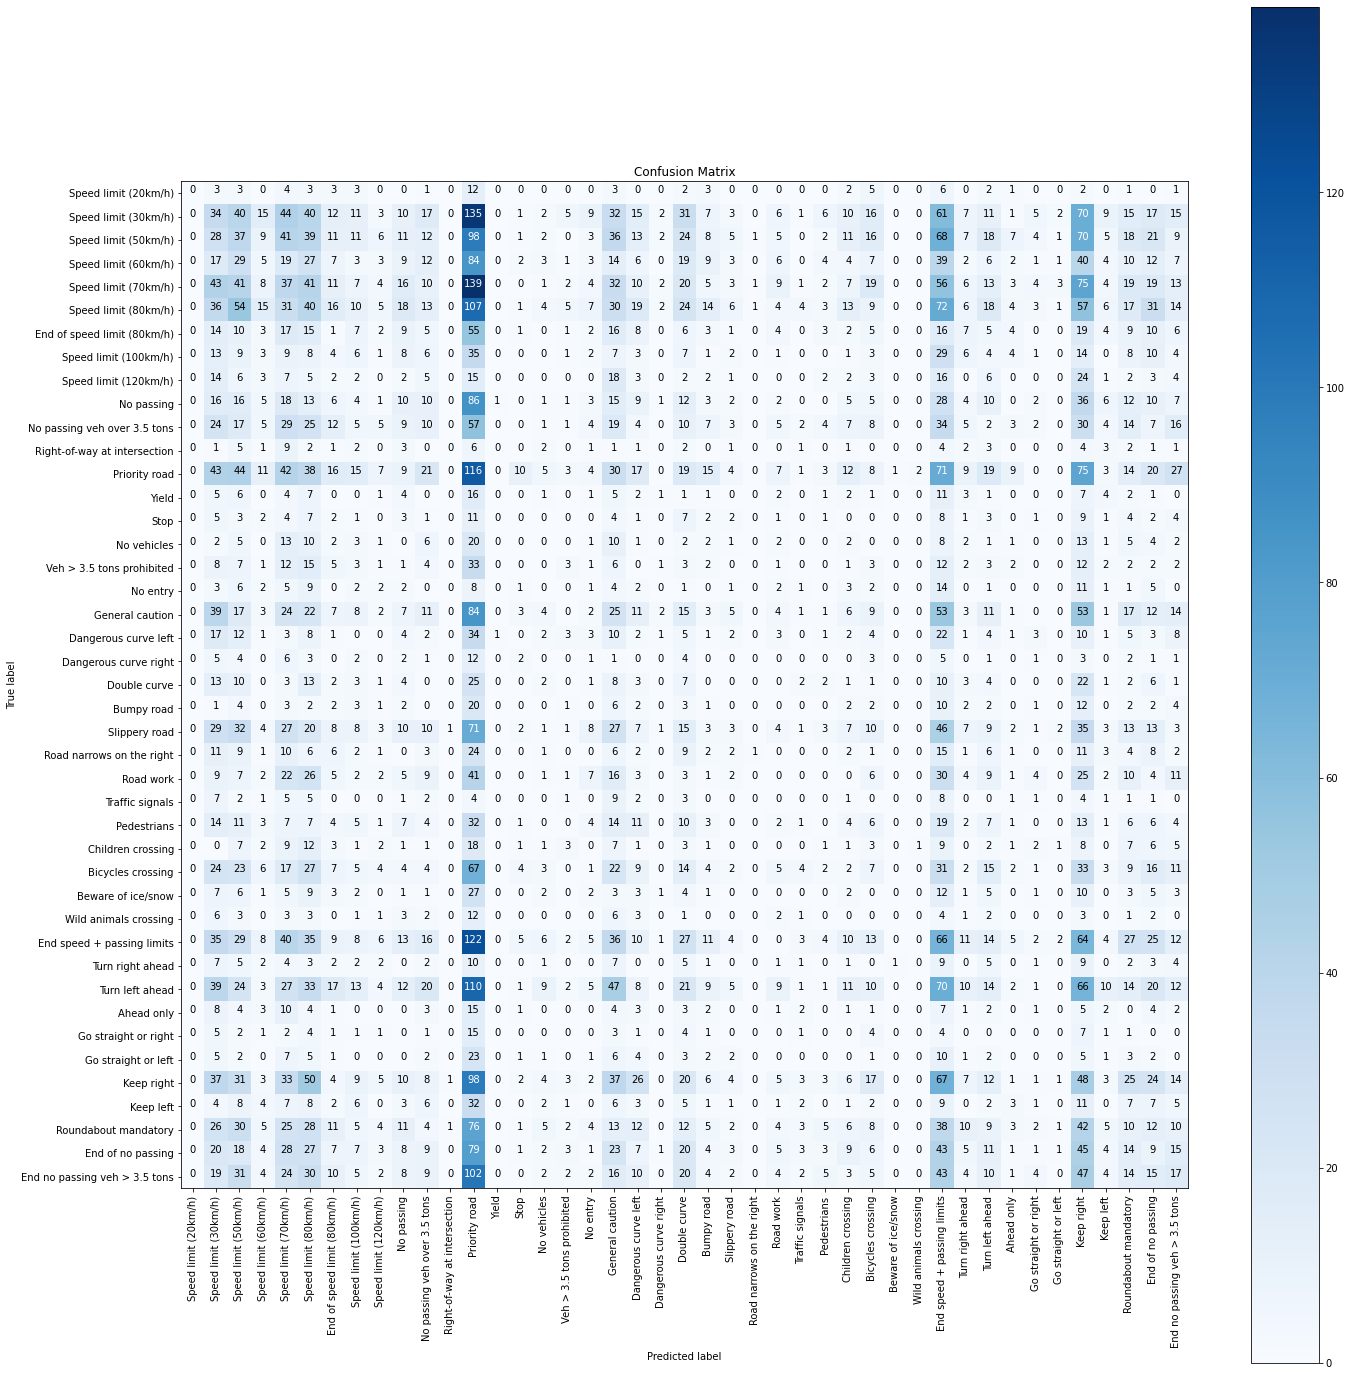

In [126]:
# predictions on Test data

Y_pred = baseline_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

Shape before entering the conv layer: (1, 32, 32, 3)


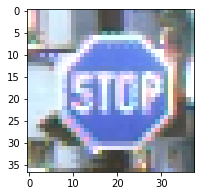

In [127]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 15, 15, 32)
(1, 13, 13, 32)
(1, 6, 6, 32)
(1, 1152)
(1, 128)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


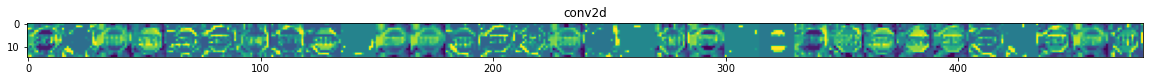

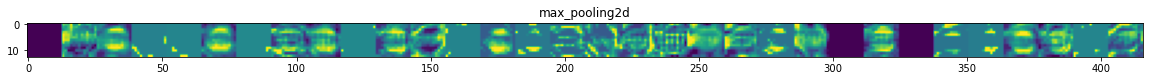

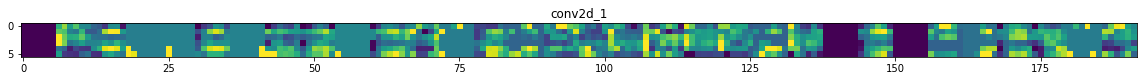

In [128]:
plot_feature_maps(baseline_model, img)

## 7 layer model

Refference: Masci, et al "A committee of neural networks for traffic sign classification" [1]

In [138]:
masci_model = Sequential()
# Refference: DLNN lecture week 6
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (4, 4), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
masci_model.add(Flatten())
# MLP - hidden layer
masci_model.add(Dense(units=200, activation=relu))
# MLP - output layer
masci_model.add(Dense(units=43, activation=softmax))

# Check built model:
masci_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 32)        16416     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 2, 32)        

In [139]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average=None)
masci_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1])

In [140]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [142]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 8
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [143]:
# MLOps init and callback
wandb.init(name='CNN_TS_masci_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_masci_model = masci_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

acc,▁▁
epoch,▁█
loss,█▁
val_acc,▁█
val_loss,█▁
acc,0.0375
best_epoch,1
best_val_loss,3.55272
epoch,1
loss,3.62175
val_acc,0.06992


Epoch 1/100
5/5 [==============================] - 22s 5s/step - loss: 3.7469 - acc: 0.0371 - f1_score: 0.0080 - val_loss: 3.6964 - val_acc: 0.0539 - val_f1_score: 0.0070
Epoch 2/100
5/5 [==============================] - 18s 4s/step - loss: 3.6445 - acc: 0.0539 - f1_score: 0.0098 - val_loss: 3.5385 - val_acc: 0.0584 - val_f1_score: 0.0039
Epoch 3/100
5/5 [==============================] - 18s 4s/step - loss: 3.5817 - acc: 0.0555 - f1_score: 0.0025 - val_loss: 3.5042 - val_acc: 0.0682 - val_f1_score: 0.0058
Epoch 4/100
5/5 [==============================] - 19s 5s/step - loss: 3.5181 - acc: 0.0688 - f1_score: 0.0083 - val_loss: 3.4775 - val_acc: 0.0643 - val_f1_score: 0.0077
Epoch 5/100
5/5 [==============================] - 23s 5s/step - loss: 3.5023 - acc: 0.0633 - f1_score: 0.0095 - val_loss: 3.4827 - val_acc: 0.0562 - val_f1_score: 0.0045
Epoch 6/100
5/5 [==============================] - 19s 4s/step - loss: 3.4593 - acc: 0.0883 - f1_score: 0.0161 - val_loss: 3.4466 - val_acc: 0.10

acc,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
time-elapsed,▁
val_acc,▁▁▂▂▃▂▃▃▄▄▅▅▅▅▆▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█████
val_loss,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
acc,0.57812
best_epoch,96
best_val_loss,1.80792
epoch,99
loss,1.35837


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


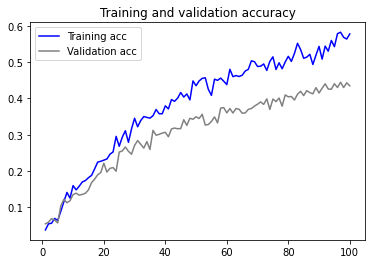

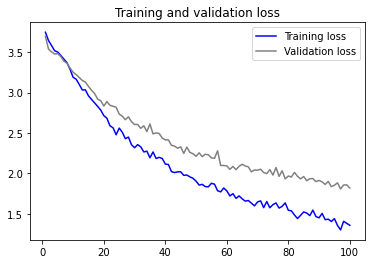

In [144]:
plot_results(history_masci_model)

Confusion matrix, without normalization
[[ 0  2  7 ...  1  3  1]
 [ 0 31 43 ... 16 47 25]
 [ 1 31 43 ... 19 39 15]
 ...
 [ 0 16 20 ...  5 25 15]
 [ 0 18 22 ... 12 26 14]
 [ 0 17 28 ... 14 27 18]]


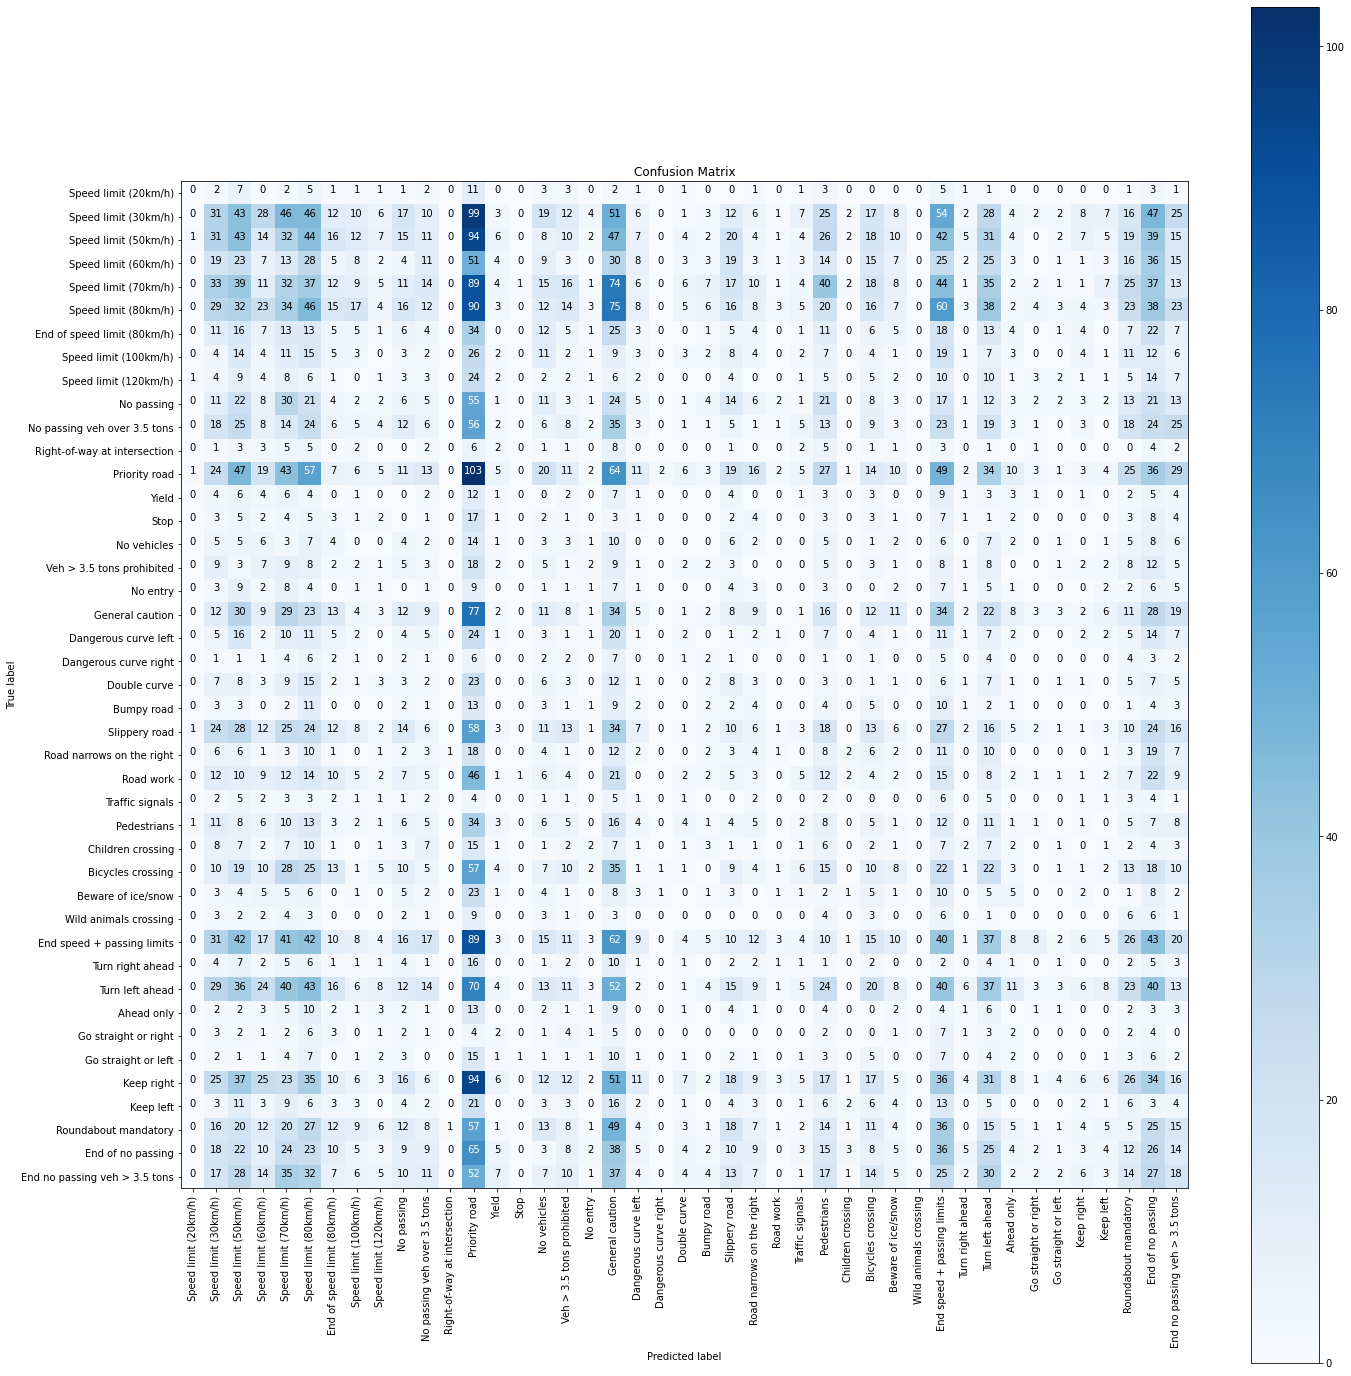

In [145]:
# predictions on Test data

Y_pred = masci_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

Shape before entering the conv layer: (1, 32, 32, 3)


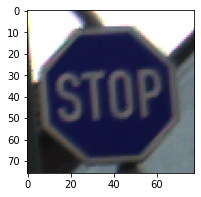

In [146]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 15, 15, 32)
(1, 12, 12, 32)
(1, 6, 6, 32)
(1, 4, 4, 32)
(1, 2, 2, 32)
(1, 128)
(1, 200)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


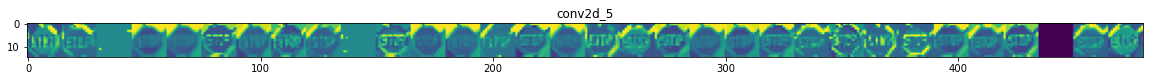

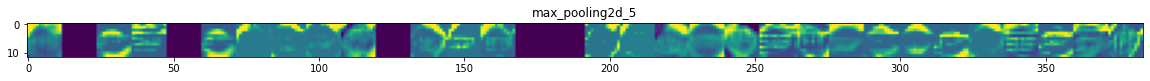

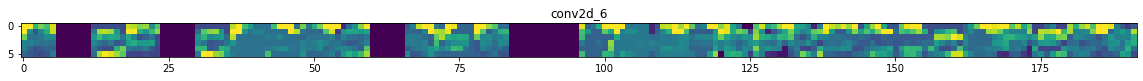

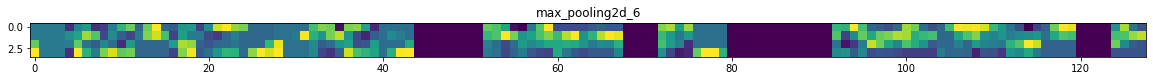

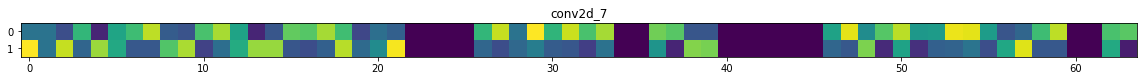

In [147]:
plot_feature_maps(masci_model, img)


## Small Scale Model

Refference: Chaudhari (et, al) "Traffic Sign Recognition Using Small-Scale Convolutional Neural Network"

In [149]:
lwm_model = Sequential()
# MLP - input layer
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
# MLP layer
lwm_model.add(Flatten())
lwm_model.add(Dense(units=256, activation=relu))
lwm_model.add(Dropout(0.25))
lwm_model.add(Dense(units=43, activation=softmax))


# Check built model:
lwm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                  

In [150]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [151]:
# adding f1-score
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average=None)

In [152]:
from tensorflow.keras import optimizers 

lwm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1 ])

In [153]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [154]:
# MLOps init and callback
wandb.init(name='CNN_TS_lwm_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_lwm_model = lwm_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/100
5/5 [==============================] - 27s 6s/step - loss: 3.6642 - acc: 0.0516 - f1_score: 0.0177 - val_loss: 3.5500 - val_acc: 0.0525 - val_f1_score: 0.0036
Epoch 2/100
5/5 [==============================] - 25s 6s/step - loss: 3.5772 - acc: 0.0703 - f1_score: 0.0148 - val_loss: 3.5457 - val_acc: 0.0795 - val_f1_score: 0.0082
Epoch 3/100
5/5 [==============================] - 24s 6s/step - loss: 3.5119 - acc: 0.0805 - f1_score: 0.0183 - val_loss: 3.5183 - val_acc: 0.0715 - val_f1_score: 0.0090
Epoch 4/100
5/5 [==============================] - 25s 6s/step - loss: 3.5025 - acc: 0.0734 - f1_score: 0.0183 - val_loss: 3.4673 - val_acc: 0.0773 - val_f1_score: 0.0108
Epoch 5/100
5/5 [==============================] - 21s 5s/step - loss: 3.3716 - acc: 0.1266 - f1_score: 0.0351 - val_loss: 3.3783 - val_acc: 0.0934 - val_f1_score: 0.0162
Epoch 6/100
5/5 [==============================] - 26s 6s/step - loss: 3.4078 - acc: 0.1016 - f1_score: 0.0258 - val_loss: 3.3784 - val_acc: 0.10

acc,▁▁▂▂▂▂▃▃▄▄▄▅▄▅▅▅▆▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▁▂▂▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇████
val_loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
acc,0.57891
best_epoch,99
best_val_loss,1.65
epoch,99
loss,1.35687


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


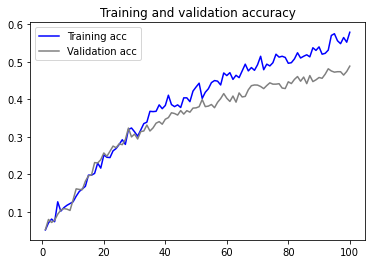

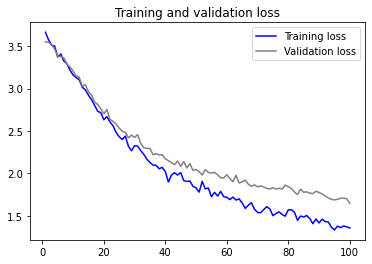

In [159]:
plot_results(history_lwm_model)

Confusion matrix, without normalization
[[ 0  5  6 ...  0  1  2]
 [ 0 44 51 ...  6  7 21]
 [ 0 43 46 ...  3 11 23]
 ...
 [ 0 32 25 ...  2  6 14]
 [ 0 20 30 ...  3  8 18]
 [ 0 32 27 ...  2  5 20]]


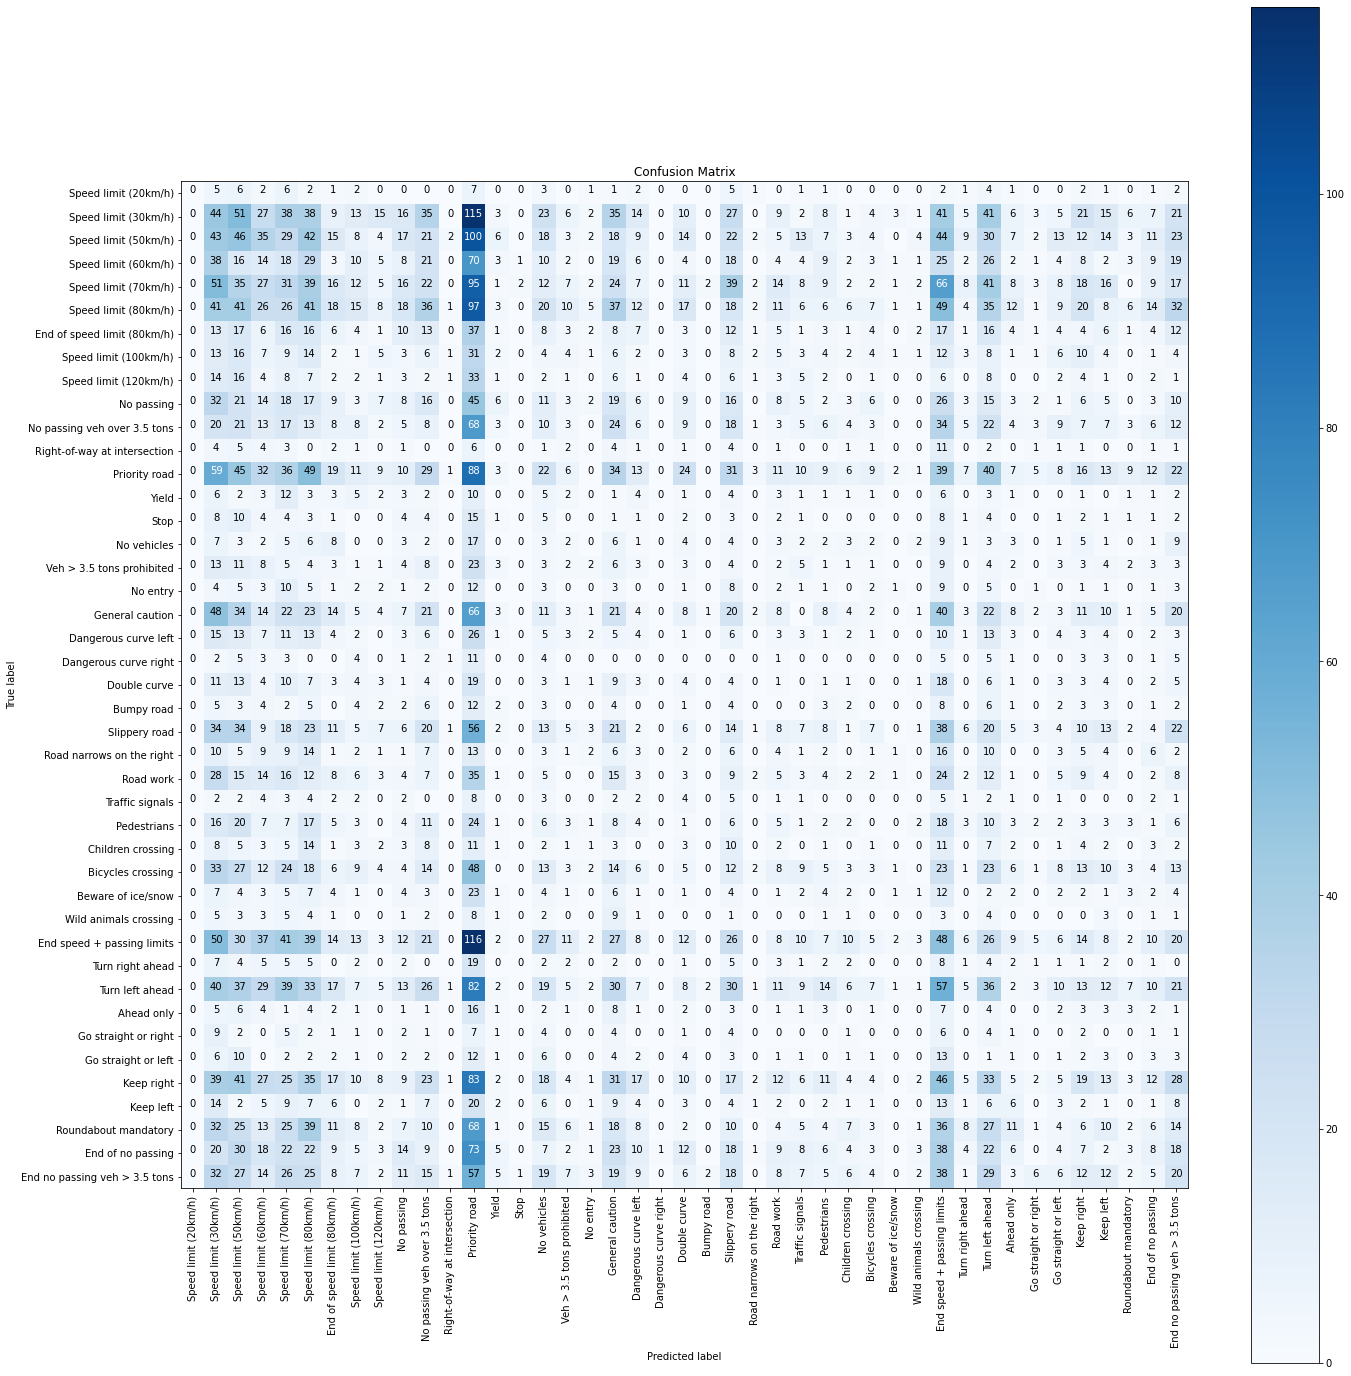

In [160]:
# predictions on Test data

Y_pred = lwm_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

Shape before entering the conv layer: (1, 32, 32, 3)


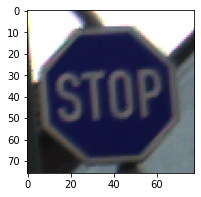

In [161]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 28, 28, 32)
(1, 14, 14, 32)
(1, 14, 14, 32)
(1, 12, 12, 32)
(1, 6, 6, 32)
(1, 6, 6, 32)
(1, 1152)
(1, 256)
(1, 256)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


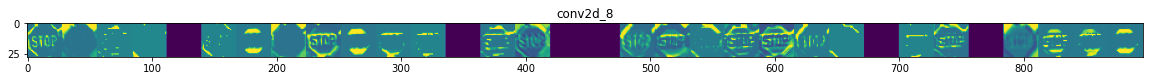

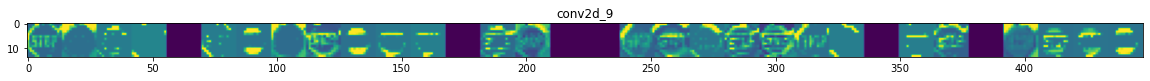

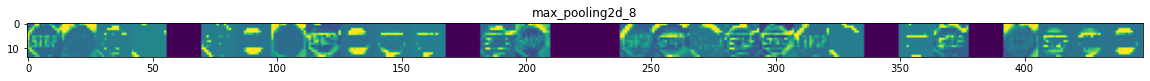

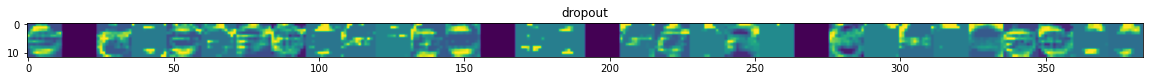

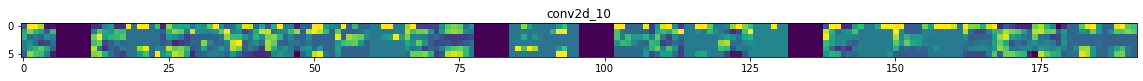

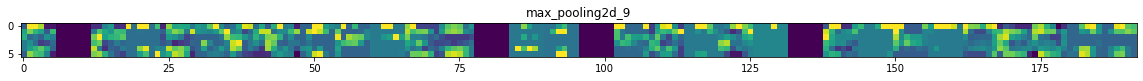

In [162]:
plot_feature_maps(lwm_model, img)

# Next Steps
- Plot the outputs of the several conv layers
- Check with different architectures:
  - See the used on the papers (masci done)
    - 2nd paper pending  - PA
    - consider a dropout layer with higher kernel values

- Check data augementation - PA
- Precision and recall metrics - JG
- Feature maps understanding  - AT / FB
- SHAP explainder - AT / FB

- Improve the acc/val loss graphs to plot multiple model curves

If time allows:
 - Check wandb sweep
 - consider different optimizers
 - consider different loss functions


# Batch Size and Epochs
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/


# 